In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the CSV data
df = pd.read_csv('./twitter_user_data.csv', encoding = "ISO-8859-1")

# Data preprocessing
# Creating a binary target variable: 1 for human (male/female), 0 for non-human (brand)
df['is_human'] = df['gender'].apply(lambda x: 1 if x in ['male', 'female'] else 0)

# Selecting relevant features
features = ['fav_number', 'retweet_count', 'tweet_count', 'profile_yn:confidence', 'description', 'created']

# Filling missing values in numerical columns (you can choose to use more sophisticated imputation methods)
df['fav_number'] = df['fav_number'].fillna(0)
df['retweet_count'] = df['retweet_count'].fillna(0)
df['tweet_count'] = df['tweet_count'].fillna(0)
df['profile_yn:confidence'] = df['profile_yn:confidence'].fillna(df['profile_yn:confidence'].mean())

# Text preprocessing for 'description' (e.g., length of description as a proxy)
df['description_length'] = df['description'].apply(lambda x: len(str(x)))

# Convert 'created' to datetime and extract the profile age in days
df['created'] = pd.to_datetime(df['created'], errors='coerce')
df['profile_age_days'] = (pd.Timestamp.now() - df['created']).dt.days.fillna(0)

# Final features for the model
X = df[['fav_number', 'retweet_count', 'tweet_count', 'profile_yn:confidence', 'description_length', 'profile_age_days']]
y = df['is_human']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)


/tmp/ipykernel_9441/2074503024.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created'] = pd.to_datetime(df['created'], errors='coerce')


Accuracy: 0.6591853699085619
Confusion Matrix:
 [[ 363 1832]
 [ 218 3602]]


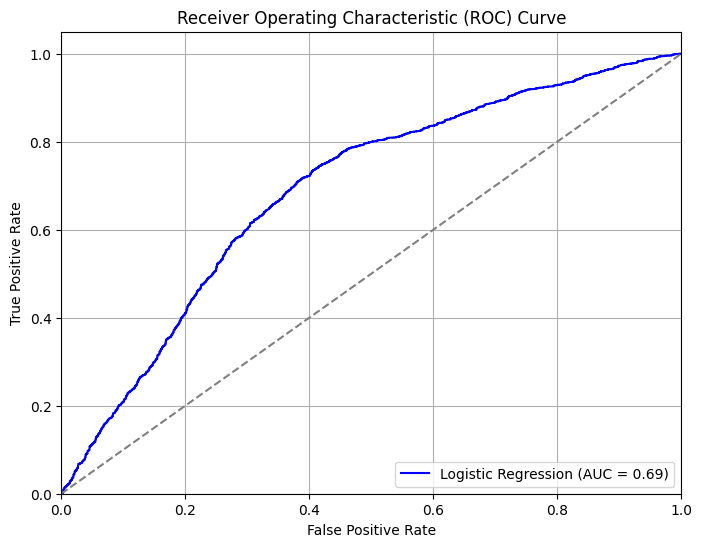

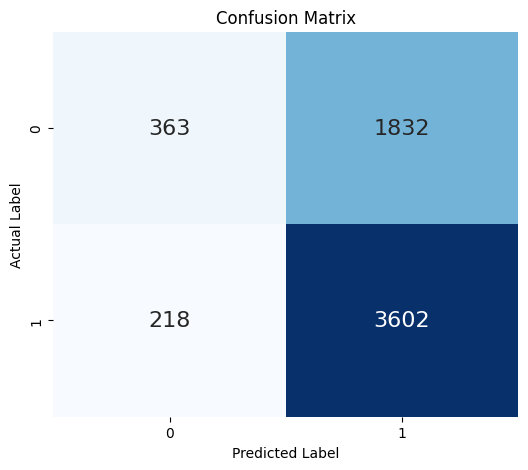

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities for ROC curve

y_pred_prob = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [6]:
# Check class distribution (imbalance)
class_distribution = y.value_counts(normalize=True)

# Print class distribution to check imbalance
class_distribution


is_human
1    0.643092
0    0.356908
Name: proportion, dtype: float64

In [7]:
# Preprocessing the target variable again: 1 for human (male/female), 0 for non-human (brand)
# df['is_human'] = df['gender'].apply(lambda x: 1 if x in ['male', 'female'] else 0)

# Checking the distribution of the 'is_human' column to see if there is class imbalance
class_distribution = df['is_human'].value_counts(normalize=True)

# Output the class distribution
class_distribution

is_human
1    0.643092
0    0.356908
Name: proportion, dtype: float64

## Apply SMOTE

In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred = model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6482128013300084
Confusion Matrix:
 [[1502  693]
 [1423 2397]]


### RESULT AFTER SMOTE: WORSE

## APPLY LOWER REGULARIZATION

In [10]:
# Apply logistic regression with regularization (L2 penalty) and C = 0.01
model = LogisticRegression(C=0.01, max_iter=1000)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6633416458852868
Confusion Matrix:
 [[ 383 1812]
 [ 213 3607]]


### RESULT AFTER LOWER REGULARIZATION: a little bit better

## TRY RANDOM FOREST

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Apply Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7634247714048212
Confusion Matrix:
 [[1189 1006]
 [ 417 3403]]


### RESULT: MUCH HIGHER

In [16]:
import xgboost as xgb

# Convert the dataset into DMatrix (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Define XGBoost parameters (these can be tuned later)
params = {
    'objective': 'binary:logistic', # Binary classification task
    'max_depth': 10,                 # Maximum tree depth
    'learning_rate': 0.01,           # Step size shrinkage
    'eval_metric': 'logloss',       # Evaluation metric
    'random_state': 42
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_prob = xgb_model.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7602660016625103
Confusion Matrix:
 [[ 974 1221]
 [ 221 3599]]


## XGBOOST YIELD SAME RESULT AS RF

## TRY ENSEMBLING

In [17]:
from sklearn.ensemble import StackingClassifier

# Define the Stacking Classifier using both Random Forest and XGBoost
estimators = [
    ('rf', rf_model),  # Random Forest
    ('xgb', xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.01, n_estimators=100, random_state=42))  # XGBoost
]

# Meta-model: Logistic Regression
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), passthrough=True)

# Train the stacking model
stack_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = stack_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Ensemble Confusion Matrix:\n", conf_matrix)


Ensemble Accuracy: 0.7632585203657523
Ensemble Confusion Matrix:
 [[1079 1116]
 [ 308 3512]]


/home/tomthanhswe/UOW/SPR24_CSCI946_BigDataAnalytics/A2_2024_Released/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


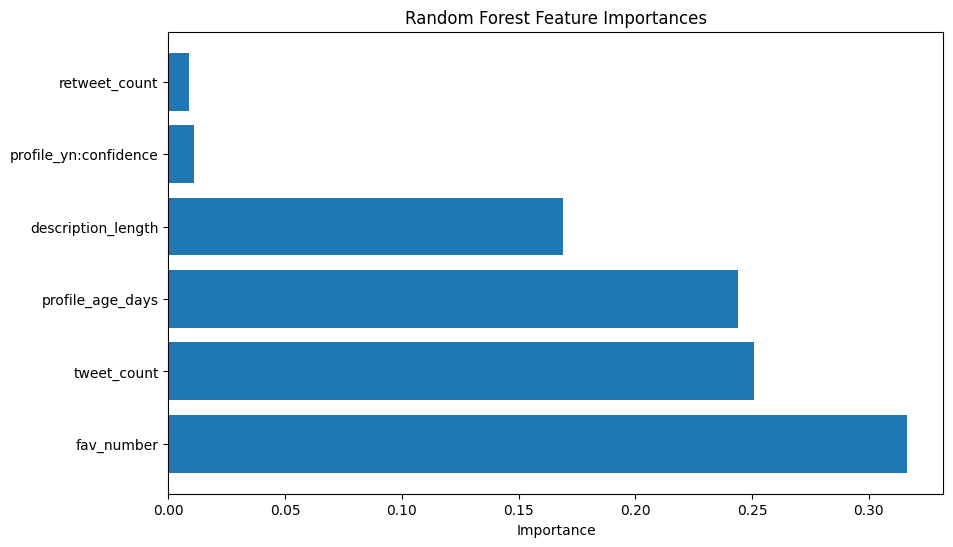

<Figure size 1000x600 with 0 Axes>

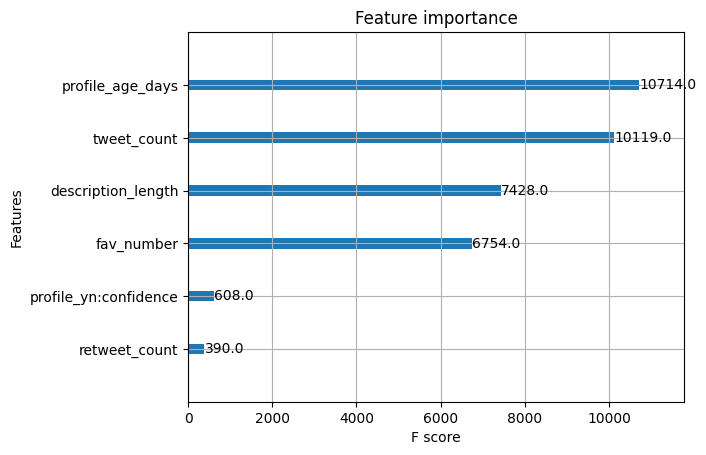

In [18]:
# Feature importance for Random Forest
plt.figure(figsize=(10,6))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.title("Random Forest Feature Importances")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), feature_names[indices])
plt.xlabel("Importance")
plt.show()

# Feature importance for XGBoost
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=10)
plt.show()